In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import logistic
import time
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from permutation_weighting.estimator import PW
from tabulate import tabulate
import seaborn as sns
from matplotlib.colors import to_rgba

def create_kang_schafer_data(n, misspecified=False):
    """
    Generate data according to Kang and Schafer (2007) simulation.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use the misspecified covariates
        
    Returns:
    --------
    dict
        Dictionary containing data and true values
    """
    # Generate true covariates
    X_true = np.random.normal(0, 1, (n, 4))
    
    # Propensity score
    linear_pred = X_true[:, 0] - 0.5 * X_true[:, 1] + 0.25 * X_true[:, 2] + 0.1 * X_true[:, 3]
    prop = logistic.cdf(linear_pred)
    
    # Treatment
    A = np.random.binomial(1, prop, n)
    
    # Outcome (note that treatment effect is zero in original paper, but 1 in this implementation)
    Y = 210 + A + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3] + np.random.normal(0, 1, n)
    
    # Observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
    else:
        X = X_true.copy()
    
    # True expected outcomes (since X are standard normal, E[X] = 0)
    true_ey0 = 210
    true_ey1 = 211  # True effect is 1
    
    return {
        'X': X,
        'A': A,
        'Y': Y,
        'true_ey0': true_ey0,
        'true_ey1': true_ey1,
    }

def compute_weights(data, method):
    """
    Compute weights using various methods.
    
    Parameters:
    -----------
    data : dict
        Data dictionary with X and A
    method : str
        Weighting method to use
        
    Returns:
    --------
    numpy.ndarray
        Weights for each observation
    """
    X = data['X']
    A = data['A']
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'IPSW (GLM)':
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'IPSW (GBM)':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'CBPS':
        # Simplified implementation - in practice you would use the CBPS package
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        # Include balance constraints by augmenting the loss function
        # (simplified for this implementation)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'SBW':
        # Simplified implementation - in practice you would use the SBW package
        model = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'PW (GLM)':
        result = PW(A, X, classifier='logit', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (GBM)':
        result = PW(A, X, classifier='boosting', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (SGD)':
        result = PW(A, X, classifier='sgd', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (MLP)':
        result = PW(A, X, classifier='mlp', num_replicates=100)
        return result['weights']
    
    else:
        raise ValueError(f"Unknown method: {method}")

def fit_outcome_model(X, Y, weights=None, model_type='OLS'):
    """
    Fit outcome model for direct method or doubly robust estimators
    
    Parameters:
    -----------
    X : array-like
        Covariate matrix
    Y : array-like
        Outcome variable
    weights : array-like, optional
        Sample weights
    model_type : str
        Type of model ('OLS' or 'RF')
        
    Returns:
    --------
    fitted model object
    """
    if model_type == 'OLS':
        model = LinearRegression()
        if weights is not None:
            model.fit(X, Y, sample_weight=weights)
        else:
            model.fit(X, Y)
    elif model_type == 'RF':
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        if weights is not None:
            model.fit(X, Y, sample_weight=weights)
        else:
            model.fit(X, Y)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    return model

def evaluate_estimators(data, weights, prob_treatment=np.array([0.5, 0.5])):
    """
    Evaluate all estimators: IPSW, Direct Method, and Doubly Robust
    
    Parameters:
    -----------
    data : dict
        Data dictionary
    weights : numpy.ndarray
        Weights for each observation
    prob_treatment: numpy.ndarray
        Probability of each treatment value [p(0), p(1)]
        
    Returns:
    --------
    dict
        Dictionary with evaluation metrics for each estimator
    """
    X = data['X']
    A = data['A']
    Y = data['Y']
    true_ey0 = data['true_ey0']
    true_ey1 = data['true_ey1']
    
    # Normalize weights to sum to n
    n = len(A)
    weights = weights / np.sum(weights) * n
    
    # Indices for treatment groups
    treated_idx = A == 1
    control_idx = A == 0
    
    # Create design matrices for outcome models
    X_with_treatment = np.column_stack([A.reshape(-1, 1), X])
    
    # Dictionary to store results
    results = {}
    
    # 1. IPSW (Model Free)
    est_ey1_ipsw = np.sum(Y[treated_idx] * weights[treated_idx]) / np.sum(weights[treated_idx])
    est_ey0_ipsw = np.sum(Y[control_idx] * weights[control_idx]) / np.sum(weights[control_idx])
    
    results['IPSW'] = {
        'est_ey0': est_ey0_ipsw,
        'est_ey1': est_ey1_ipsw,
        'diff0': est_ey0_ipsw - true_ey0,
        'diff1': est_ey1_ipsw - true_ey1
    }
    
    # 2. Direct Method - OLS
    dm_ols = fit_outcome_model(X_with_treatment, Y, weights=weights, model_type='OLS')
    
    # Create counterfactual datasets
    X_cf0 = np.column_stack([np.zeros(n).reshape(-1, 1), X])
    X_cf1 = np.column_stack([np.ones(n).reshape(-1, 1), X])
    
    est_ey0_dm_ols = np.mean(dm_ols.predict(X_cf0))
    est_ey1_dm_ols = np.mean(dm_ols.predict(X_cf1))
    
    results['DM-OLS'] = {
        'est_ey0': est_ey0_dm_ols,
        'est_ey1': est_ey1_dm_ols,
        'diff0': est_ey0_dm_ols - true_ey0,
        'diff1': est_ey1_dm_ols - true_ey1
    }
    
    # 3. Direct Method - RF
    dm_rf = fit_outcome_model(X_with_treatment, Y, weights=weights, model_type='RF')
    
    est_ey0_dm_rf = np.mean(dm_rf.predict(X_cf0))
    est_ey1_dm_rf = np.mean(dm_rf.predict(X_cf1))
    
    results['DM-RF'] = {
        'est_ey0': est_ey0_dm_rf,
        'est_ey1': est_ey1_dm_rf,
        'diff0': est_ey0_dm_rf - true_ey0,
        'diff1': est_ey1_dm_rf - true_ey1
    }
    
    # 4. Doubly Robust - OLS
    # Predict outcomes for each unit under their observed treatment
    y_pred_ols = dm_ols.predict(X_with_treatment)
    
    # Calculate augmented predictions
    dr_0_ols = np.zeros(n)
    dr_1_ols = np.zeros(n)
    
    # For units with A=0, use observed outcome; for A=1, use model prediction
    dr_0_ols[control_idx] = Y[control_idx]
    dr_0_ols[treated_idx] = dm_ols.predict(np.column_stack([np.zeros(sum(treated_idx)).reshape(-1, 1), X[treated_idx]]))
    
    # For units with A=1, use observed outcome; for A=0, use model prediction
    dr_1_ols[treated_idx] = Y[treated_idx]
    dr_1_ols[control_idx] = dm_ols.predict(np.column_stack([np.ones(sum(control_idx)).reshape(-1, 1), X[control_idx]]))
    
    # Apply residual adjustment
    residuals = Y - y_pred_ols
    
    # Weight the adjusted outcomes
    est_ey0_dr_ols = np.sum(dr_0_ols * weights) / np.sum(weights)
    est_ey1_dr_ols = np.sum(dr_1_ols * weights) / np.sum(weights)
    
    results['DR-OLS'] = {
        'est_ey0': est_ey0_dr_ols,
        'est_ey1': est_ey1_dr_ols,
        'diff0': est_ey0_dr_ols - true_ey0,
        'diff1': est_ey1_dr_ols - true_ey1
    }
    
    # 5. Doubly Robust - RF
    # Predict outcomes for each unit under their observed treatment
    y_pred_rf = dm_rf.predict(X_with_treatment)
    
    # Calculate augmented predictions
    dr_0_rf = np.zeros(n)
    dr_1_rf = np.zeros(n)
    
    # For units with A=0, use observed outcome; for A=1, use model prediction
    dr_0_rf[control_idx] = Y[control_idx]
    dr_0_rf[treated_idx] = dm_rf.predict(np.column_stack([np.zeros(sum(treated_idx)).reshape(-1, 1), X[treated_idx]]))
    
    # For units with A=1, use observed outcome; for A=0, use model prediction
    dr_1_rf[treated_idx] = Y[treated_idx]
    dr_1_rf[control_idx] = dm_rf.predict(np.column_stack([np.ones(sum(control_idx)).reshape(-1, 1), X[control_idx]]))
    
    # Apply residual adjustment
    residuals_rf = Y - y_pred_rf
    
    # Weight the adjusted outcomes
    est_ey0_dr_rf = np.sum(dr_0_rf * weights) / np.sum(weights)
    est_ey1_dr_rf = np.sum(dr_1_rf * weights) / np.sum(weights)
    
    results['DR-RF'] = {
        'est_ey0': est_ey0_dr_rf,
        'est_ey1': est_ey1_dr_rf,
        'diff0': est_ey0_dr_rf - true_ey0,
        'diff1': est_ey1_dr_rf - true_ey1
    }
    
    return results

def run_simulation(n_sims=48, sample_sizes=None, methods=None, misspecified=False):
    """
    Run the Kang-Schafer simulation.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulations for each configuration
    sample_sizes : list
        List of sample sizes to evaluate
    methods : list
        List of weighting methods to evaluate
    misspecified : bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    pandas.DataFrame
        Simulation results
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000, 3500, 5000]
    
    if methods is None:
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'CBPS', 'SBW', 'PW (GLM)', 'PW (GBM)']
    
    results = []
    
    for n in sample_sizes:
        print(f"Running simulations for n={n}, misspecified={misspecified}")
        
        for sim in range(n_sims):
            if sim % 10 == 0:
                print(f"  Simulation {sim+1}/{n_sims}")
            
            # Generate data
            data = create_kang_schafer_data(n, misspecified)
            
            for method in methods:
                try:
                    # Compute weights
                    weights = compute_weights(data, method)
                    
                    # Evaluate all estimators
                    eval_results = evaluate_estimators(data, weights)
                    
                    # Record results
                    for estimator, metrics in eval_results.items():
                        results.append({
                            'sample_size': n,
                            'simulation': sim,
                            'method': method,
                            'estimator': estimator,
                            'diff0': metrics['diff0'],
                            'diff1': metrics['diff1'],
                            'est_ey0': metrics['est_ey0'],
                            'est_ey1': metrics['est_ey1'],
                            'true_ey0': data['true_ey0'],
                            'true_ey1': data['true_ey1']
                        })
                
                except Exception as e:
                    print(f"Error with method {method} on simulation {sim} with n={n}: {e}")
    
    return pd.DataFrame(results)

def compute_metrics(results):
    """
    Compute metrics from simulation results.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    pandas.DataFrame
        Computed metrics
    """
    # Group by method, estimator, and sample size
    grouped = results.groupby(['method', 'estimator', 'sample_size'])
    
    # Compute integrated mean absolute bias and IRMSE
    metrics = grouped.apply(lambda x: pd.Series({
        'bias': np.mean([np.abs(x['diff0']).mean(), np.abs(x['diff1']).mean()]),
        'bias_sem': np.sqrt(np.var([np.abs(x['diff0']).mean(), np.abs(x['diff1']).mean()]) / 2),
        'irmse': np.sqrt(np.mean([np.mean(x['diff0'] ** 2), np.mean(x['diff1'] ** 2)])),
        'irmse_sem': np.sqrt(np.var([np.sqrt(np.mean(x['diff0'] ** 2)), np.sqrt(np.mean(x['diff1'] ** 2))]) / 2)
    })).reset_index()
    
    return metrics

def format_with_sem(value, sem, precision=2):
    """Format value with standard error for display in tables"""
    return f"{value:.{precision}f} ± {sem:.{precision}f}"

def create_results_table(metrics, sample_size=2000):
    """
    Create a formatted results table for a specific sample size.
    
    Parameters:
    -----------
    metrics : pandas.DataFrame
        Computed metrics
    sample_size : int
        Sample size to show results for
        
    Returns:
    --------
    dict
        Dictionary containing table data
    """
    # Filter for the specific sample size
    ss_metrics = metrics[metrics['sample_size'] == sample_size]
    
    # Create table structure
    estimators = ['IPSW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
    methods = ss_metrics['method'].unique()
    
    # Initialize table data
    table_data = {
        'bias': {},
        'irmse': {}
    }
    
    # Fill in the data
    for method in methods:
        for estimator in estimators:
            method_est_data = ss_metrics[(ss_metrics['method'] == method) & 
                                        (ss_metrics['estimator'] == estimator)]
            if not method_est_data.empty:
                # Format bias with SEM
                bias = method_est_data['bias'].values[0]
                bias_sem = method_est_data['bias_sem'].values[0]
                table_data['bias'][f"{method}_{estimator}"] = format_with_sem(bias, bias_sem)
                
                # Format IRMSE with SEM
                irmse = method_est_data['irmse'].values[0]
                irmse_sem = method_est_data['irmse_sem'].values[0]
                table_data['irmse'][f"{method}_{estimator}"] = format_with_sem(irmse, irmse_sem)
            else:
                table_data['bias'][f"{method}_{estimator}"] = "N/A"
                table_data['irmse'][f"{method}_{estimator}"] = "N/A"
    
    return {
        'estimators': estimators,
        'methods': methods,
        'data': table_data,
        'sample_size': sample_size
    }

def print_table(table_data, title="Results"):
    """
    Print a formatted table of results.
    
    Parameters:
    -----------
    table_data : dict
        Table data from create_results_table
    title : str
        Table title
    """
    estimators = table_data['estimators']
    methods = table_data['methods']
    data = table_data['data']
    sample_size = table_data['sample_size']
    
    # Create headers
    headers = ["Metric", "Estimator"] + list(methods)
    
    # Create rows
    rows = []
    
    # Add bias rows
    for estimator in estimators:
        row = ["Bias", estimator]
        for method in methods:
            row.append(data['bias'][f"{method}_{estimator}"])
        rows.append(row)
    
    # Add IRMSE rows
    for estimator in estimators:
        row = ["IRMSE", estimator]
        for method in methods:
            row.append(data['irmse'][f"{method}_{estimator}"])
        rows.append(row)
    
    # Print table
    print(f"\n{title}\nN = {sample_size}\n")
    print(tabulate(rows, headers=headers, tablefmt="grid"))

def plot_results(metrics, title, save_path=None):
    """
    Plot results similar to the R output.
    """
    # Filter only for IPSW estimator
    ipsw_metrics = metrics[metrics['estimator'] == 'IPSW']
    
    # Bootstrap for robust estimates
    n_bootstrap = 100
    bootstrap_results = []
    
    # Setup for bootstrapping
    methods = ipsw_metrics['method'].unique()
    sample_sizes = ipsw_metrics['sample_size'].unique()
    
    # Prepare data structure for bootstrapping
    method_samples = {}
    for method in methods:
        method_samples[method] = {}
        for ss in sample_sizes:
            subset = ipsw_metrics[(ipsw_metrics['method'] == method) & 
                                  (ipsw_metrics['sample_size'] == ss)]
            if not subset.empty:
                method_samples[method][ss] = subset
    
    # Perform bootstrap
    for _ in range(n_bootstrap):
        bootstrap_data = []
        for method in methods:
            for ss in sample_sizes:
                if ss in method_samples[method]:
                    # Sample with replacement
                    bs_idx = np.random.choice(len(method_samples[method][ss]), 
                                             size=len(method_samples[method][ss]), 
                                             replace=True)
                    bs_sample = method_samples[method][ss].iloc[bs_idx]
                    
                    # Calculate mean for this bootstrap sample
                    bs_mean = pd.DataFrame({
                        'method': [method],
                        'sample_size': [ss],
                        'bias': [bs_sample['bias'].mean()],
                        'irmse': [bs_sample['irmse'].mean()]
                    })
                    bootstrap_data.append(bs_mean)
        
        bootstrap_results.append(pd.concat(bootstrap_data))
    
    # Combine bootstrap results
    all_bootstrap = pd.concat(bootstrap_results)
    
    # Calculate mean and standard error across bootstraps
    agg_data = all_bootstrap.groupby(['method', 'sample_size']).agg({
        'bias': ['mean', 'std'],
        'irmse': ['mean', 'std']
    }).reset_index()
    
    # Rename columns for easier access
    agg_data.columns = ['method', 'sample_size', 'bias_mean', 'bias_sem', 'irmse_mean', 'irmse_sem']
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Set a consistent color palette - using common colors for methods
    palette = {
        'PW (GBM)': '#1f77b4',     # blue
        'PW (GLM)': '#ff7f0e',     # orange
        'PW (MLP)': '#2ca02c',     # green
        'PW (SGD)': '#d62728',     # red
        'Unweighted': '#9467bd',   # purple
        'IPSW (GLM)': '#8c564b',   # brown
        'IPSW (GBM)': '#e377c2',   # pink
        'CBPS': '#7f7f7f',         # gray
        'SBW': '#bcbd22'           # yellow
    }
    
    # Plot for each method
    for method in agg_data['method'].unique():
        method_data = agg_data[agg_data['method'] == method]
        
        # Plot Integrated Mean Absolute Bias
        axes[0].errorbar(
            method_data['sample_size'],
            method_data['bias_mean'],
            yerr=method_data['bias_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[0].plot(
            method_data['sample_size'],
            method_data['bias_mean'],
            color=palette.get(method, None)
        )
        
        # Plot Integrated RMSE
        axes[1].errorbar(
            method_data['sample_size'],
            method_data['irmse_mean'],
            yerr=method_data['irmse_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[1].plot(
            method_data['sample_size'],
            method_data['irmse_mean'],
            color=palette.get(method, None)
        )
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias')
    axes[0].set_xlabel('Sample Size')
    axes[0].set_ylabel('Metric Value')
    
    axes[1].set_title('Integrated RMSE')
    axes[1].set_xlabel('Sample Size')
    axes[1].set_ylabel('Metric Value')
    
    # Set scale and grid
    for ax in axes:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xticks(sorted(agg_data['sample_size'].unique()))
        ax.set_xticklabels(sorted(agg_data['sample_size'].unique()))
        ax.grid(True, alpha=0.3)
    
    # Add legend to the right of the plot
    axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.suptitle(f'{title} - Kang & Schafer Simulation (IPSW Estimator)')
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

def create_summary_table_image(metrics, sample_size=2000, title="", save_path=None):
    """
    Create a publication-ready summary table image
    
    Parameters:
    -----------
    metrics : pandas.DataFrame
        Computed metrics
    sample_size : int
        Sample size to display results for
    title : str
        Table title
    save_path : str, optional
        Path to save the image
        
    Returns:
    --------
    None
    """
    # Filter for the specific sample size
    ss_metrics = metrics[metrics['sample_size'] == sample_size]
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Define the column structure
    estimators = ['IPSW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
    methods = sorted(ss_metrics['method'].unique())
    
    # Create the table data
    table_data = []
    
    # Header row
    header = ['Estimator', 'Metric'] + methods
    table_data.append(header)
    
    # Data rows
    for estimator in estimators:
        # Bias row
        bias_row = [estimator, 'Bias']
        # IRMSE row
        irmse_row = ['', 'IRMSE']
        
        for method in methods:
            method_est_data = ss_metrics[(ss_metrics['method'] == method) & 
                                        (ss_metrics['estimator'] == estimator)]
            
            if not method_est_data.empty:
                bias = method_est_data['bias'].values[0]
                bias_sem = method_est_data['bias_sem'].values[0]
                bias_row.append(format_with_sem(bias, bias_sem))
                
                irmse = method_est_data['irmse'].values[0]
                irmse_sem = method_est_data['irmse_sem'].values[0]
                irmse_row.append(format_with_sem(irmse, irmse_sem))
            else:
                bias_row.append('N/A')
                irmse_row.append('N/A')
        
        table_data.append(bias_row)
        table_data.append(irmse_row)
    
    # Create the table
    table = ax.table(
        cellText=table_data[1:],
        colLabels=table_data[0],
        loc='center',
        cellLoc='center',
        colColours=['#f2f2f2'] * len(table_data[0])
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Add a title
    plt.title(f"{title} - N = {sample_size}", fontsize=14, pad=20)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def run_kang_schafer_simulation(test_run=False):
    """
    Run the complete Kang-Schafer simulation.
    
    Parameters:
    -----------
    test_run : bool
        Whether to run a smaller test simulation
    
    Returns:
    --------
    dict
        Simulation results and metrics
    """
    # Configuration
    if test_run:
        n_sims = 5
        sample_sizes = [500]
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'PW (GLM)', 'PW (GBM)']
        title_suffix = " (Test Run)"
    else:
        n_sims = 5
        sample_sizes = [2000]
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'CBPS', 'SBW', 'PW (GLM)', 'PW (GBM)', 'PW (MLP)', 'PW (SGD)']
        title_suffix = ""
    
    # Well-specified simulation
    print("Running well-specified simulation...")
    start_time = time.time()
    well_specified_results = run_simulation(
        n_sims=n_sims, 
        sample_sizes=sample_sizes, 
        methods=methods, 
        misspecified=False
    )
    well_specified_metrics = compute_metrics(well_specified_results)
    print(f"Well-specified simulation completed in {time.time() - start_time:.2f} seconds")
    
    # Create table for sample size 2000
    well_specified_table = create_results_table(well_specified_metrics, sample_size=2000)
    print_table(well_specified_table, title=f"Well-specified{title_suffix}")
    
    # Create summary table image
    create_summary_table_image(
        well_specified_metrics, 
        sample_size=2000, 
        title=f"Well-specified{title_suffix}", 
        save_path=f"binary_well_specified_table{'_test' if test_run else ''}.png"
    )
    
    # # Plot well-specified results
    # plot_results(
    #     well_specified_metrics, 
    #     f"Well-specified{title_suffix}", 
    #     save_path=f"binary_well_specified_plot{'_test' if test_run else ''}.png"
    # )
    
    # Misspecified simulation
    print("Running misspecified simulation...")
    start_time = time.time()
    misspecified_results = run_simulation(
        n_sims=n_sims, 
        sample_sizes=sample_sizes, 
        methods=methods, 
        misspecified=True
    )
    misspecified_metrics = compute_metrics(misspecified_results)
    print(f"Misspecified simulation completed in {time.time() - start_time:.2f} seconds")
    
    # Create table for sample size 2000
    misspecified_table = create_results_table(misspecified_metrics, sample_size=2000)
    print_table(misspecified_table, title=f"Misspecified{title_suffix}")
    
    # Create summary table image
    create_summary_table_image(
        misspecified_metrics, 
        sample_size=2000, 
        title=f"Misspecified{title_suffix}", 
        save_path=f"binary_misspecified_table{'_test' if test_run else ''}.png"
    )
    
    # # Plot misspecified results
    # plot_results(
    #     misspecified_metrics, 
    #     f"Misspecified{title_suffix}", 
    #     save_path=f"binary_misspecified_plot{'_test' if test_run else ''}.png"
    # )
    
    return {
        'well_specified_results': well_specified_results,
        'well_specified_metrics': well_specified_metrics,
        'misspecified_results': misspecified_results,
        'misspecified_metrics': misspecified_metrics
    }

Running well-specified simulation...
Running simulations for n=2000, misspecified=False
  Simulation 1/5


/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_1855/3789362950.py:404: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = grouped.apply(lambda x: pd.Series({


Well-specified simulation completed in 23.32 seconds

Well-specified
N = 2000

+----------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+
| Metric   | Estimator   | CBPS        | IPSW (GBM)   | IPSW (GLM)   | PW (GBM)    | PW (GLM)    | PW (MLP)    | PW (SGD)    | SBW         | Unweighted   |
+==========+=============+=============+==============+==============+=============+=============+=============+=============+=============+==============+
| Bias     | IPSW        | 0.95 ± 0.01 | 3.27 ± 0.13  | 0.95 ± 0.01  | 2.92 ± 0.21 | 1.64 ± 0.09 | 1.92 ± 0.18 | 1.66 ± 0.13 | 1.03 ± 0.04 | 9.74 ± 0.10  |
+----------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+
| Bias     | DM-OLS      | 0.58 ± 0.00 | 0.57 ± 0.01  | 0.58 ± 0.00  | 0.57 ± 0.00 | 0.58 ± 0.01 | 0.58 ± 0.00 | 0.58 ± 0.01 | 0.58 ± 0.00 | 

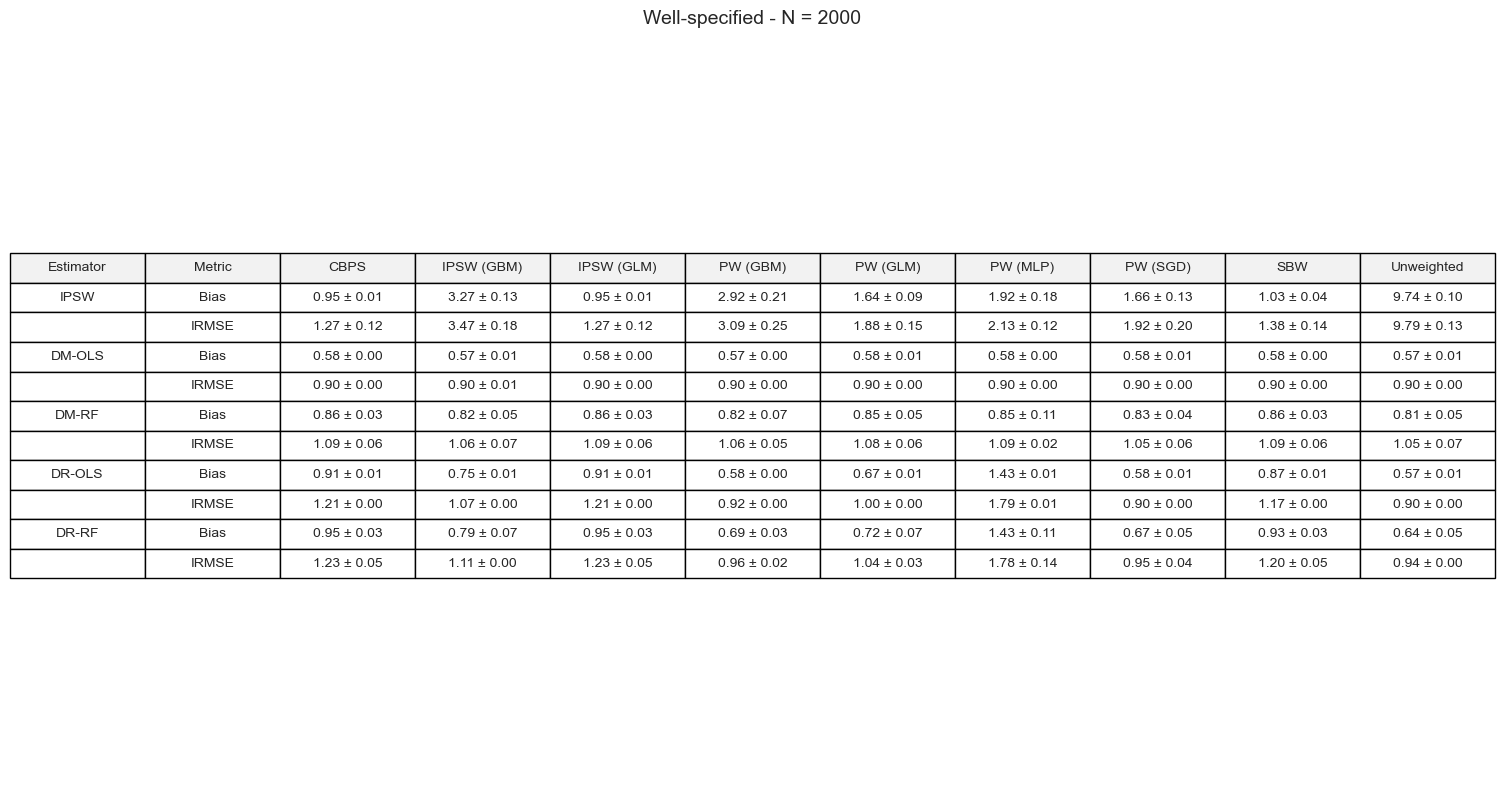

Running misspecified simulation...
Running simulations for n=2000, misspecified=True
  Simulation 1/5


/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_1855/3789362950.py:404: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = grouped.apply(lambda x: pd.Series({


Misspecified simulation completed in 21.33 seconds

Misspecified
N = 2000

+----------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+
| Metric   | Estimator   | CBPS        | IPSW (GBM)   | IPSW (GLM)   | PW (GBM)    | PW (GLM)    | PW (MLP)    | PW (SGD)    | SBW         | Unweighted   |
+==========+=============+=============+==============+==============+=============+=============+=============+=============+=============+==============+
| Bias     | IPSW        | 3.57 ± 0.18 | 3.79 ± 0.26  | 3.57 ± 0.18  | 3.48 ± 0.02 | 2.91 ± 1.03 | 2.50 ± 0.59 | 2.83 ± 0.74 | 3.44 ± 0.69 | 9.60 ± 0.07  |
+----------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+
| Bias     | DM-OLS      | 3.10 ± 0.16 | 1.34 ± 0.58  | 3.10 ± 0.16  | 1.68 ± 0.33 | 3.12 ± 0.52 | 1.88 ± 0.01 | 3.13 ± 0.50 | 3.29 ± 0.12 | 3.10

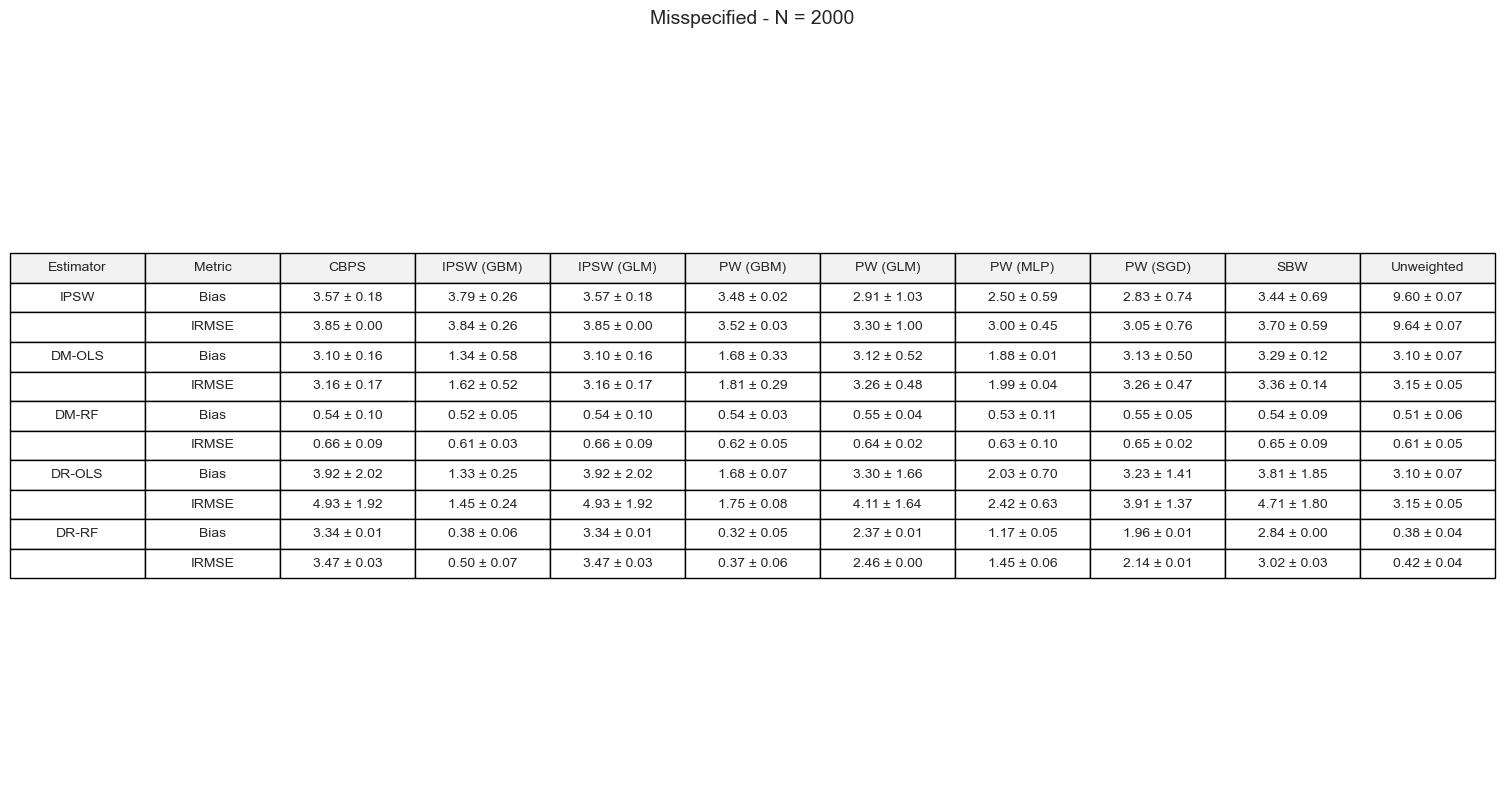

In [17]:
if __name__ == "__main__":
    # Run the full simulation
    results = run_kang_schafer_simulation(test_run=False)
